# Second iteration of model - dynamic network

After some interactions a new link is formed between two random agents 

The first to be defined is a state space, here being set to be discrete values. 
Then the Agent class is defined to set an initial state and a method to "consider" it's state options and possibly changing it's state. 

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
#import pygraphviz as pgv
from statistics import stdev, mean
import imageio
import networkx as nx


#Constants and Variables

states = [1, -1] #1 being cooperating, -1 being defecting

defectorUtility = -0.2 
 
politicalClimate=0.2 

selfWeight = 0.8

neighboursWeight = 0.5

In [12]:

class Agent:
    def __init__(self, state):
        self.state = state
        self.interactionsReceived = 0
        self.interactionsGiven = 0
    
    def consider(self, neighbour, neighboursWeight):
        self.interactionsReceived +=1
        neighbour.addInteractionGiven()
        weight = self.state*selfWeight + politicalClimate + defectorUtility + neighboursWeight*neighbour.state + random.uniform(-0.25, 0.25)
        
        #self.state = weight
        if(weight > 0):
            self.state = states[0]
        else:
            self.state = states[1]  
    
    def addInteractionGiven(self):
        self.interactionsGiven +=1
        
    def groupConsider(self, neighbourList):
        return
        
        

In [13]:
def standardDeviation(fc):
    res = 4*fc*(1-fc)**3+24*(fc*(1-fc))**2+36*(1-fc)*fc**3+16*fc**4-16*fc**2
    return (res)

In [ ]:


def correlation(model, depth):
    AgreeingNeighbours = [[0 for i in range(depth)] for j in range(len(model.graph))]
    
    for nodeIdx in model.graph:
        neighbours = list(model.graph.adj[nodeIdx])
        isCooperator = model.graph.nodes[nodeIdx]['agent'].state > 0
        parent = [nodeIdx]
        for d in range(depth):
            nextLevelNeighs = set([])
            for n in neighbours:
                nextLevelNeighs.update(list(model.graph.adj[n]))
                if(model.graph.nodes[n]['agent'].state > 0 and isCooperator):
                    AgreeingNeighbours[nodeIdx][d] += 1
                elif(model.graph.nodes[n]['agent'].state <= 0 and not isCooperator): 
                    AgreeingNeighbours[nodeIdx][d] += 1
            for n in parent:
                nextLevelNeighs.discard(n) 
            parent = neighbours
            neighbours = nextLevelNeighs
            
    mat = np.matrix(AgreeingNeighbours)
    avg = mat.mean(axis=0)
    arrays = [[] for i in range(depth)]
    res = [0 for i in range(depth)]
    for nodeIdx in model.graph:
        neighbours = list(model.graph.adj[nodeIdx])
        for d in range(depth):
            for n in neighbours:
                arrays[d].append((AgreeingNeighbours[nodeIdx][d]-avg[0, d])*(AgreeingNeighbours[n][d]-avg[0, d]))
    for d in range(depth):
        res[d] = mean(arrays[d])
        
    return res

The model class consists of the agents and includes a method to make these interact. 

In [22]:
class Model:
    def __init__(self, generator, *argv):        
        self.graph = nx.Graph()
        self.ratio = []
        self.defectorDefectingNeighsList = []
        self.cooperatorDefectingNeighsList = []
        self.defectorDefectingNeighsSTDList = []
        self.cooperatorDefectingNeighsSTDList =[]
        self.pos = []
        self.runMethods = []
        generator(self, *argv)
        
    def addMethod(self, method, *args, **kwargs):
        self.runMethods.append({'method' : method,'args' :  *args, 'kwargs' : **kwargs})
    
    def run(self):
        print(self.runMethods)
    
    def interact(self):
        nodeIndex = random.randint(0, len(self.graph) - 1)
        node = self.graph.nodes[nodeIndex]['agent']
        
        neighbours =  list(self.graph.adj[nodeIndex].keys())
        
        chosenNeighbourIndex = neighbours[random.randint(0, len(neighbours)-1)]
        chosenNeighbour = self.graph.nodes[chosenNeighbourIndex]['agent']
        
        weight = self.graph[nodeIndex][chosenNeighbourIndex]['weight']
        
        node.consider(chosenNeighbour, weight)
        
    def getAvgNumberOfDefectorNeigh(self):
        defectorFriendsList = []
        defectorNeighboursList = []
        for node in self.graph:
            agreeingNeighbours = 0
            neighbours = list(self.graph.adj[node])
            for neighbourIndex in neighbours:
                if self.graph.nodes[neighbourIndex]['agent'].state == self.graph.nodes[node]['agent'].state:
                    agreeingNeighbours += 1
            if self.graph.nodes[node]['agent'].state== 1:
                defectorNeighboursList.append(agreeingNeighbours) #defectorNeighboursList.append(agreeingNeighbours/len(neighbours))
            else:
                defectorFriendsList.append(agreeingNeighbours)
        
        defectoravg = mean(defectorFriendsList)
        cooperatoravg =mean(defectorNeighboursList)
        defectorSTD = stdev(defectorFriendsList)
        cooperatorSTD =stdev(defectorNeighboursList)
        return(defectoravg, cooperatoravg, defectorSTD, cooperatorSTD)
                
    
    def countCooperatorRatio(self):
        count = 0
        for node in self.graph:
            if self.graph.nodes[node]['agent'].state > 0:
                count+=1
        return count/len(self.graph)
 
    def runSim(self, k, drawModel = False, countNeighbours = False, gifname=None):
        
        if(drawModel):
            draw_model(self)
            filenames = []
        
        if(countNeighbours):
            (defectorDefectingNeighs,
             cooperatorDefectingFriends,
             defectorDefectingNeighsSTD,
             cooperatorDefectingFriendsSTD) = self.getAvgNumberOfDefectorNeigh()
            print("Defectors: avg: ", defectorDefectingNeighs, " std: ", defectorDefectingNeighsSTD)
            print("Cooperators: avg: ", cooperatorDefectingFriends, " std: ", cooperatorDefectingFriendsSTD)
    
        for i in range(k):
            self.interact()
            ratio = self.countCooperatorRatio()
            self.ratio.append(ratio)
            #self.politicalClimate += (ratio-0.5)*0.001 #change the political climate depending on the ratio of cooperators
            
            if(countNeighbours):
                (defectorDefectingNeighs,
                 cooperatorDefectingNeighs,
                 defectorDefectingNeighsSTD,
                 cooperatorDefectingNeighsSTD) = self.getAvgNumberOfDefectorNeigh()
                self.defectorDefectingNeighsList.append(defectorDefectingNeighs)
                self.cooperatorDefectingNeighsList.append(cooperatorDefectingNeighs)
                self.defectorDefectingNeighsSTDList.append(defectorDefectingNeighsSTD)
                self.cooperatorDefectingNeighsSTDList.append(cooperatorDefectingNeighsSTD)
            if(drawModel and (gifname != None) and (i % 10 == 0)):
                draw_model(self, True, i)
                filenames.append("plot" + str(i) +".png")
                
            #if(i % 10 == 0):
                #a = random.randint(0,n)
                #b = random.randint(0,n)
                #while(a==b):
                    #b = random.randint(0,n)
                    #weight = random.uniform(0.1, 0.9)
                    #model.graph.add_edge(a, b, weight = weight)
        if(drawModel and (gifname != None)):
            images = []
            for filename in filenames:
                images.append(imageio.imread(filename))
            imageio.mimsave("network" +gifname+ ".gif", images, duration=0.04167)
       
    
        if(countNeighbours):
            drawDefectingNeighbours(self.defectorDefectingNeighsList,
                                    self.cooperatorDefectingNeighsList,
                                    self.defectorDefectingNeighsSTDList,
                                    self.cooperatorDefectingNeighsSTDList, 
                                    gifname)
        
        return self.ratio

SyntaxError: invalid syntax (<ipython-input-22-a8009ee7a99e>, line 14)

In [5]:
def makeGridModel(model, n):
    
    for i in range(n):
        for j in range (n):
            weight=random.uniform(0.1, 0.9)
            agent1 = Agent(states[random.randint(0,1)])
            model.graph.add_node(i*n+j, agent=agent1, pos=(i, j))
            model.pos.append((i, j))
            if(i!=0):
                model.graph.add_edge(i*n+j, (i-1)*n+j, weight = weight)
            if(j!=0):
                model.graph.add_edge(i*n+j, i*n+j-1, weight = weight)
    
    return model

In [6]:
def makeRandomModel(model, n, m):

    model.graph = nx.barabasi_albert_graph(n, m)
    
    for n in range (n):
            agent1 = Agent(states[random.randint(0,1)])
            model.graph.nodes[n]['agent'] = agent1
    edges = model.graph.edges() 
    for e in edges: 
        weight=random.uniform(0.1, 0.9)
        model.graph[e[0]][e[1]]['weight'] = weight 
    #pos = nx.nx_agraph.graphviz_layout(model.graph)
    #pos = nx.graphviz_layout(model.graph)
    pos = nx.kamada_kawai_layout(model.graph)
# bipartite_layout(G, nodes[, align, scale, …])	Position nodes in two straight lines.
#circular_layout(G[, scale, center, dim])	Position nodes on a circle.
#kamada_kawai_layout(G[, dist, pos, weight, …])	Position nodes using Kamada-Kawai path-length cost-function.
#random_layout(G[, center, dim, seed])	Position nodes uniformly at random in the unit square.
#rescale_layout(pos[, scale])	Return scaled position array to (-scale, scale) in all axes.
##shell_layout(G[, nlist, scale, center, dim])	Position nodes in concentric circles.
#spring_layout(G[, k, pos, fixed, …])	Position nodes using Fruchterman-Reingold force-directed algorithm.
#spectral_layout(G[, weight, scale, center, dim])	Position nodes using the eigenvectors of the graph Laplacian. 

    model.pos = pos
    
    return model

In [7]:
import matplotlib.pyplot as plt
from IPython.display import Image


def draw_model(model, save=False, filenumber = None):

    color_map = []
    #pos = []
    for node in model.graph:
        #pos.append(model.graph.nodes[node]['pos'])
        if model.graph.nodes[node]['agent'].state== 1:
            color_map.append('#03a45e')
        else: color_map.append('#f7796d')   
    
    plt.subplot(121)
    nx.draw(model.graph, model.pos, node_color = color_map, )
    if(save):
        plt.savefig("plot" + str(filenumber) +".png", bbox_inches="tight")


In [8]:
  
def drawDefectingNeighbours(defectorDefectingNeighsList, cooperatorDefectingNeighsList, defectorDefectingNeighsSTDList, cooperatorDefectingNeighsSTDList, filname = None):
    steps = range(0, len(defectorDefectingNeighsList))
    defector = np.array( defectorDefectingNeighsList)
    defectorSTD = np.array( defectorDefectingNeighsSTDList)
    cooperator = np.array(cooperatorDefectingNeighsList)
    cooperatorSTD = np.array( cooperatorDefectingNeighsSTDList)
     
    plt.figure(figsize=(12, 9))  
    
    f, axarr = plt.subplots(2, sharex=True)
    axarr[0].set_title('Development of defector neighbours')
  
    # Remove the plot frame lines. They are unnecessary chartjunk.  
    #axarr[0] = plt.subplot(111)  
    #ax.spines["top"].set_visible(False)  
    #ax.spines["right"].set_visible(False)  
   
    #ax.get_xaxis().tick_bottom()  
    #ax.get_yaxis().tick_left()  
   
  
    # Along the same vein, make sure your axis labels are large  
    # enough to be easily read as well. Make them slightly larger  
    # than your axis tick labels so they stand out.  
    plt.ylabel("avg number of defector friends", fontsize=12)  
  
    # Use matplotlib's fill_between() call to create error bars.    
    axarr[0].fill_between(steps, cooperator - cooperatorSTD,  
                 cooperator + cooperatorSTD,  color="#397c39")  
  
    # Plot the means as a white line in between the error bars.   
    # White stands out best against the dark blue.  
    axarr[0].plot(steps, cooperatorDefectingNeighsList, color="white", lw=2) 
   
    axarr[1].fill_between(steps, defector - defectorSTD,  
                 defector + defectorSTD,  color="#7c393a")  
  
    # Plot the means as a white line in between the error bars.   
    # White stands out best against the dark blue.  
    axarr[1].plot(steps, defectorDefectingNeighsList, color="white", lw=2) 
    
    #plt.title("Development of defector neighbours", fontsize=22)  
    
  
    # Finally, save the figure as a PNG.  
    # You can also save it as a PDF, JPEG, etc.  
    # Just change the file extension in this call.  
    # bbox_inches="tight" removes all the extra whitespace on the edges of your plot.  
    plt.savefig("avg" + filname +".png", bbox_inches="tight");
    
def drawSD(ratio, defectorDefectingNeighsSDList, cooperatorDefectingNeighsSDList):
    steps = range(0, len(defectorDefectingNeighsSDList))
    defectorSD = np.array( defectorDefectingNeighsSDList)
    cooperatorSD = np.array( cooperatorDefectingNeighsSDList)
    ratioArr = np.array(ratio)
    oppositeRatioArr = 1 - ratioArr
    #print(ratioArr, oppositeRatioArr)
    sd = standardDeviation(ratioArr)
    defsd = standardDeviation(oppositeRatioArr)
    #print(sd, defsd)
    
    plt.title("Estimated SD for random distribution - SD at all time steps ")
    plt.xlabel("Timesteps")
    plt.plot(steps, sd -cooperatorSD, color="#397c39")
    plt.plot(steps, defsd- defectorSD, color="#7c393a")

In [15]:
def simulate(generate, k, *argv, **kwargs):
    model = Model(generate, *argv)
    #model = makeRandomModel(n, 4)  
    ratio = model.runSim(k, **kwargs)
    return (model, ratio)

def batch_simulate(n,k,s, **kwargs):
    batch_proportions=[]
    
    for i in range(s):
        (model, proportion) = simulate(n, k, **kwargs)
        batch_proportions.append(proportion)
    
    return batch_proportions 

TypeError: append() takes no keyword arguments

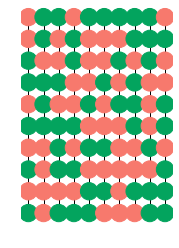

In [19]:
(model, ratio) = simulate(makeGridModel, 1000, 10, drawModel=True)
model.addMethod(Model.runSim, 1000, drawModel = True)

In [10]:
(proportions) = batch_simulate(20, 3000, 100)
plt.xlabel("timesteps")
plt.ylabel("fraction of cooperators")
plt.ylim((0, 1))
for i in range(20):
    plt.plot(proportions)

TypeError: 'int' object is not callable

c:\users\sigrid\appdata\local\programs\python\python36\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


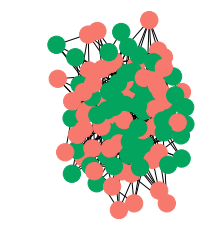

In [18]:
(model, ratio) = simulate(100, 3000, drawModel=True)

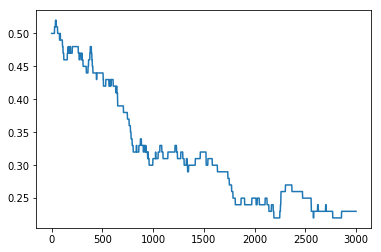

In [23]:
#radialDist(model, 6, False)
plt.plot(model.ratio)

 ...]

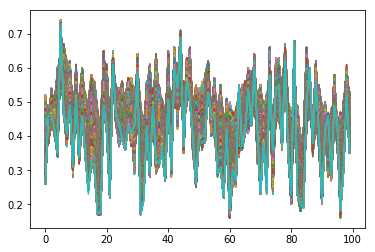

In [40]:
plt.plot(proportions)

## Radial Distribution function
Calculate the number of agreeing nodes per number of jumps out from the node

In [20]:
def radialDist(model, depth, isBefore):
    DefectorValues = [[0 for i in range(depth)] for j in range(len(model.graph))]
    CooperatorValues = [[0 for i in range(depth)] for j in range(len(model.graph))]
    
    for nodeIdx in model.graph:
        neighbours = list(model.graph.adj[nodeIdx])
        isCooperator = model.graph.nodes[nodeIdx]['agent'].state > 0
        parent = [nodeIdx]
        for d in range(depth):
            nextLevelNeighs = set([])
            for n in neighbours:
                nextLevelNeighs.update(list(model.graph.adj[n]))
                if(model.graph.nodes[n]['agent'].state > 0 and isCooperator):
                    CooperatorValues[nodeIdx][d] += 1
                elif(model.graph.nodes[n]['agent'].state <= 0 and not isCooperator): 
                    DefectorValues[nodeIdx][d] += 1
            CooperatorValues[nodeIdx][d] = CooperatorValues[nodeIdx][d]/len(neighbours)
            DefectorValues[nodeIdx][d] = DefectorValues[nodeIdx][d]/len(neighbours)
            
            #make sure the parent level isn't checked again
            for n in parent:
                nextLevelNeighs.discard(n) 
            parent = neighbours
            neighbours = nextLevelNeighs
     
    cooperatorRatio = model.countCooperatorRatio()
    
    cooperatorRes = []
    defectorRes = []
    for col in range(depth):
        coopSumRatios = 0
        defectSumRatios = 0
        for row in range(len(CooperatorValues)):
            coopSumRatios += CooperatorValues[row][col]
            defectSumRatios += DefectorValues[row][col]
        cooperatorRes.append(np.array(coopSumRatios)/(len(model.graph)*cooperatorRatio*cooperatorRatio))
        defectorRes.append(np.array(defectSumRatios)/(len(model.graph)*(1-cooperatorRatio)*(1-cooperatorRatio)))

    if isBefore:
        intensity = 0.5
    else:
        intensity = 1
    plt.xlabel("Distance from the nodes")
    plt.ylabel("Normalised ratio of agreein neighbours")
    plt.title("Distance distribution function")
    plt.ylim((0, 2.5))
    plt.plot(range(1, len(cooperatorRes)+1), cooperatorRes, color=((23/255, 104/255, 37/255, intensity)))     plt.plot(range(1, len(cooperatorRes)+1), defectorRes, color=((109/255, 10/255, 10/255, intensity))) 

SyntaxError: invalid syntax (<ipython-input-20-6ed14a2f8e06>, line 47)

TypeError: 'int' object is not iterable

In [15]:


    
#(results) = batch_simulate(12, 10000, 10, weight =random.gauss(0.5, 0.2))

#for i in results:
    #plt.plot(i)

c:\users\sigrid\appdata\local\programs\python\python36\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


[0.27272727272727276, 0.547979797979798, 1.0348099046015713]


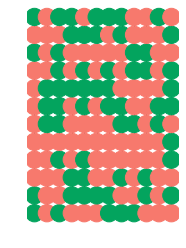

In [44]:
model = makeGridModel(12)
draw_model(model)
print(correlation(model, 3))
ratio = model.runSim(2000)

[0.273989898989899, 0.34515291806958476, 1.4809904601571267]


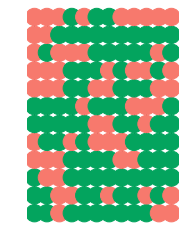

In [76]:
draw_model(model)
print(correlation(model, 3))

0.41
Defectors: avg:  0.7372881355932204  std:  0.2728159348725995
Cooperators: avg:  0.3882113821138211  std:  0.312144106286553


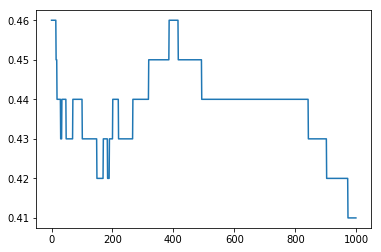

In [40]:
plt.plot(ratio)
print(model.countCooperatorRatio())
(defectorDefectingNeighs, cooperatorDefectingFriends, defectorDefectingNeighsSTD, cooperatorDefectingFriendsSTD)=model.getAvgNumberOfDefectorNeigh()
print("Defectors: avg: ", defectorDefectingNeighs, " std: ", defectorDefectingNeighsSTD)
print("Cooperators: avg: ", cooperatorDefectingFriends, " std: ", cooperatorDefectingFriendsSTD)
        

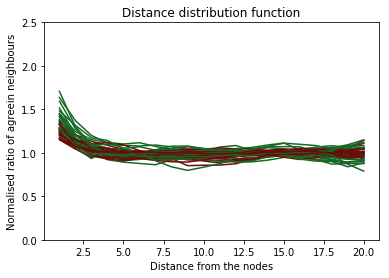

In [37]:
for i in range(20):
    model=makeGridModel(20)
    model.runSim(10000)
    radialDist(model, 20, False)

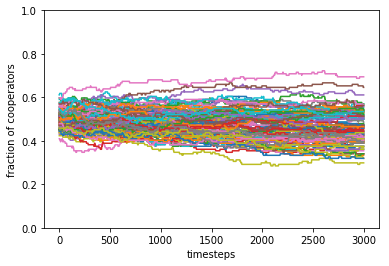

In [35]:
plt.xlabel("timesteps")
plt.ylabel("fraction of cooperators")
plt.ylim((0, 1))
for i in range(100):
    model=makeGridModel(12)
    model.runSim(3000)
    plt.plot(model.ratio)

In [6]:
def foo(method):
    method()
    
def helloWorld(name):
    print("hello ", name)
    


foo(lambda: helloWorld("Sigrid"))


hello  Sigrid
